In [123]:
#importing library
import numpy as np
import pandas as pd
pd.set_option('Display.max_columns',None)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report

In [124]:
#loading the dataset
df=pd.read_csv('/kaggle/input/apartment-rental-offers-in-germany/immo_data.csv')
#showing the dataset
df

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.40,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.00,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.90,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,NaN,False,True,0,2.74,10.0,910.0,2016.0,115641081,1.0,geothermal,False,Bayern,True,9.0,820.0,NaN,90.00,Weilheim_Schongau_Kreis,mint_condition,sophisticated,no,no_information,NaN,False,6,roof_storey,82390,3.0,NaN,NaN,NaN,3,False,4,Weilheim_Schongau_Kreis,Eberfing,"Diese schöne, neuwertige Wohnung im Dachgescho...",Fliesen und Parkett. Sichtbarer Dachstuhl.,NaN,NaN,NaN,NaN,NaN,Feb20
268846,Hessen,220.00,gas_heating,NaN,NaN,False,True,12,6.49,NaN,1150.0,1983.0,96981497,1.0,gas,True,Hessen,False,4.0,930.0,NaN,115.00,Bergstraße_Kreis,well_kept,sophisticated,negotiable,no_information,NaN,False,6,apartment,68519,3.5,NaN,1.0,1.0,3,False,5,Bergstraße_Kreis,Viernheim,Hier wird eine Wohnung im 2 Familienhaus angeb...,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",NaN,NaN,2015.0,NaN,NaN,May19
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,NaN,False,True,21,2.90,40.0,930.0,1965.0,66924271,1.0,gas,False,Hessen,True,2.0,650.0,10,95.00,Limburg_Weilburg_Kreis,well_kept,NaN,negotiable,Emsbachstrasse,Emsbachstrasse,False,5,apartment,65552,4.0,160.77,1.0,2.0,4,True,4,Limburg_Weilburg_Krei

In [125]:
#getting preliminary information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [126]:
#checking the number of unique value in each column
{column:len(df[column].unique()) for column in df.columns if df[column].dtype=='object'}

{'regio1': 16,
 'heatingType': 14,
 'telekomTvOffer': 4,
 'firingTypes': 133,
 'geo_bln': 16,
 'houseNumber': 5511,
 'geo_krs': 419,
 'condition': 11,
 'interiorQual': 5,
 'petsAllowed': 4,
 'street': 52373,
 'streetPlain': 54491,
 'typeOfFlat': 11,
 'regio2': 419,
 'regio3': 8684,
 'description': 212622,
 'facilities': 189527,
 'energyEfficiencyClass': 11,
 'date': 4}

In [127]:
#checking the missing values in the dataset
[df.isna().sum()>0.30].index

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [166]:
def onehot_encode(df,column):
    df=df.copy()
    dummies=pd.get_dummies(df[column],prefix=column)
    for col in dummies.columns:    
        dummies[col]=dummies[col].astype(int)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    return df
    

In [175]:
def preprocess_inputs(df):
    df=df.copy()
    #drpping high cardinality columns
    
    columns_to_drop=['houseNumber','street','streetPlain','regio3','description','facilities']
    df=df.drop(columns_to_drop,axis=1)
    missing_value_columns=df.loc[:,df.isna().mean()>0.30].columns
    
    #dropping the column with more than 30 percent missing values
    df=df.drop(missing_value_columns,axis=1)
    
    #Encoding lable columns
    
    index_with_missing_labels=df.loc[df['typeOfFlat'].isna(),:].index
    
    
    #dropping the rows with missing labels
    df=df.drop(index_with_missing_labels,axis=0).reset_index(drop=True)
    
    
    df['IsApartment']=df['typeOfFlat'].apply(lambda x:1 if x=='apartment' else 0)
    
    df=df.drop('typeOfFlat',axis=1)
    
    
    columns_with_missing_values=df.loc[:,df.isna().sum()>0]
    
    categorical_missing_columns=columns_with_missing_values.select_dtypes('object').columns
    numerical_missing_columns=columns_with_missing_values.drop(categorical_missing_columns,axis=1).columns
    
    
    #filling missing values with mean of that column
    
    for column in numerical_missing_columns:
        df[column]=df[column].fillna(df[column].mean())
        
    #filling missing value in categorical columns
    
    for column in categorical_missing_columns:
        df[column]=df[column].fillna('missing')
          
    for column in df.columns:
        if df[column].dtype=='bool':
            df[column]=df[column].astype(int)
    
    df['date']=pd.to_datetime(df['date'],format='%b%y')
    
    df['date_month']=df['date'].apply(lambda x:x.month)
    df['date_year']=df['date'].apply(lambda x:x.year)
    
    df=df.drop('date',axis=1)
    
    for column in df.columns:
        if df[column].dtype=='object':
            df=onehot_encode(df,column)
    y=df['IsApartment']
    x=df.drop('IsApartment',axis=1)
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=123,shuffle=True)
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x_train.columns,index=x_train.index)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)
            


    return x_train,x_test,y_train,y_test

In [177]:
x_train,x_test,y_train,y_test=preprocess_inputs(df)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(162565, 1047)
(69671, 1047)
(162565,)
(69671,)


# Constructing and Training the Model

In [180]:
inputs=tf.keras.Input(shape=(x_train.shape[1],))
x=tf.keras.layers.Dense(64,activation='relu')(inputs)
x=tf.keras.layers.Dense(64,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1047)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,297 (278.50 KB)

 Trainable params: 71,297 (278.50 KB)

 Non-trainable params: 0 (0.00 B)

In [182]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
batch_size=64
epochs=100

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])


Epoch 1/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5983 - auc: 0.6180 - loss: 0.6699 - val_accuracy: 0.6259 - val_auc: 0.6727 - val_loss: 0.6373
Epoch 2/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6331 - auc: 0.6792 - loss: 0.6322 - val_accuracy: 0.6400 - val_auc: 0.6882 - val_loss: 0.6266
Epoch 3/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6499 - auc: 0.7025 - loss: 0.6171 - val_accuracy: 0.6673 - val_auc: 0.7223 - val_loss: 0.6102
Epoch 4/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6859 - auc: 0.7477 - loss: 0.5860 - val_accuracy: 0.6946 - val_auc: 0.7581 - val_loss: 0.5815
Epoch 5/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7040 - auc: 0.7720 - loss: 0.5642 - val_accuracy: 0.7014 - val_auc: 0.7689 - val_loss: 0.5734
Epoch 6/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7195 - auc: 0.7928 - loss: 0.5440 - val_accuracy: 0.7094 - val_auc: 0.7792 - val_loss: 0.5630
Epoch 7/100
2033/2033 

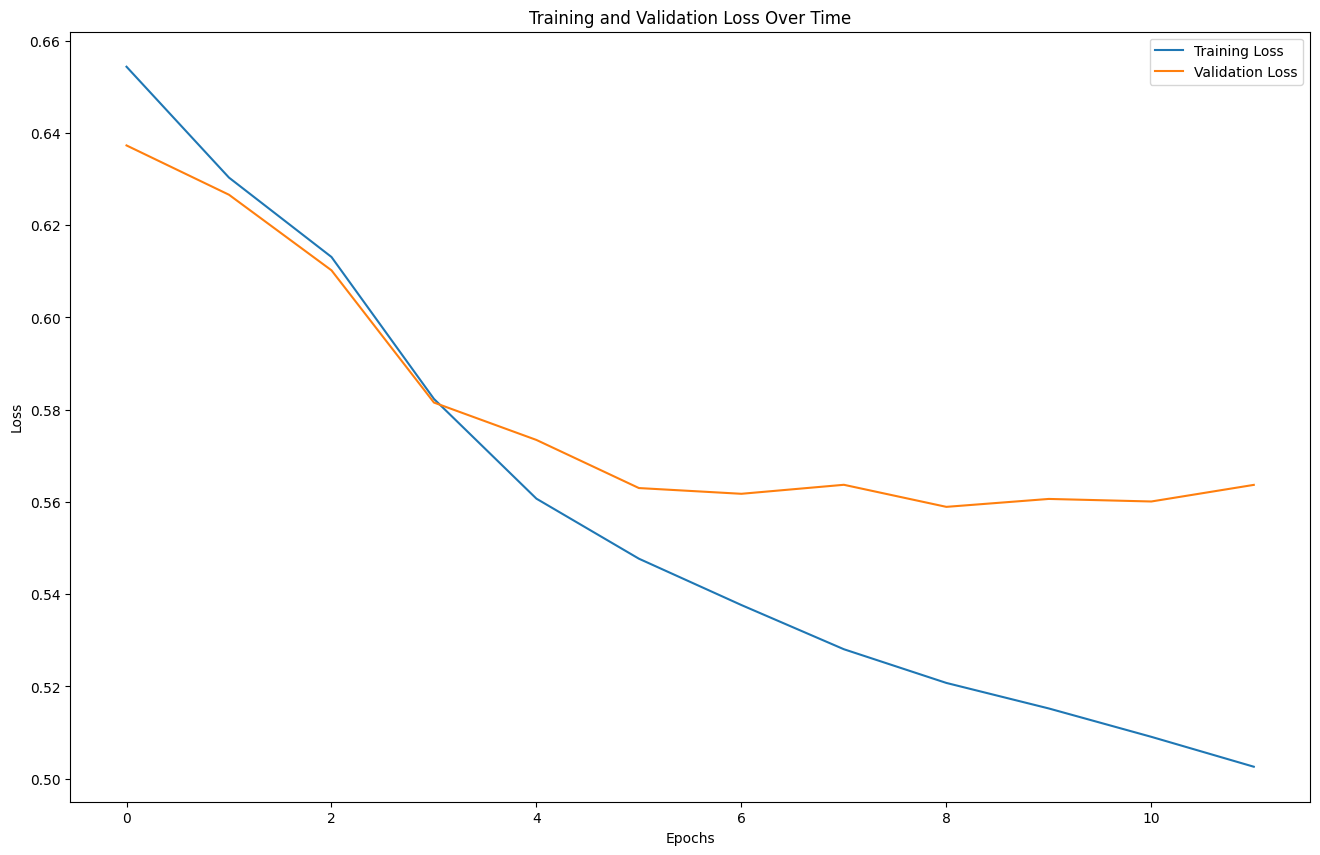

In [185]:
epochs_range=range(len(history.history['loss']))
plt.figure(figsize=(16,10))
plt.plot(epochs_range,history.history['loss'],label='Training Loss')
plt.plot(epochs_range,history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [187]:
model.evaluate(x_test,y_test)

2178/2178 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7082 - auc: 0.7772 - loss: 0.5631


[0.562664270401001, 0.7093769311904907, 0.7783910036087036]

In [ ]:
x.select_dtypes('object').isna().sum()